In [95]:
#case2

import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

data = pd.read_csv('data/HR_data_2.csv')
#print header
print(data.head())


   Unnamed: 0  HR_TD_Mean  HR_TD_Median  HR_TD_std  HR_TD_Min  HR_TD_Max  \
0           0   78.663878         76.70   7.480043      67.25      92.48   
1           1   76.540732         76.61   2.584756      69.82      82.33   
2           2   78.173563         77.92   2.681255      72.22      82.80   
3           3   83.073688         83.88   7.363598      69.42      96.12   
4           4   72.281250         72.91   3.193762      64.95      79.98   

   HR_TD_AUC  HR_TD_Kurtosis  HR_TD_Skew  HR_TD_Slope_min  ...  upset  \
0  23048.450       -1.091448    0.369955          -0.7300  ...    1.0   
1  23959.920       -0.245338    0.338732          -0.3600  ...    2.0   
2  20324.605       -0.615922   -0.233047          -0.6300  ...    1.0   
3  24924.300       -0.866610   -0.046021          -0.4650  ...    1.0   
4  23052.100        0.200401   -0.560948          -0.3725  ...    3.0   

   hostile  alert  ashamed  inspired  nervous  attentive  afraid  active  \
0      1.0    2.0      1.0  

In [2]:
from tqdm import tqdm
from etna.transforms.embeddings.models import TS2VecEmbeddingModel

# Load pretrained model
model = TS2VecEmbeddingModel.load(model_name='ts2vec_tiny')
model.embedding_model.batch_size = 1


c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\settings.py:51: UserWarning: etna[chronos] is not available, to install it, run `pip install etna[chronos]`
  warnings.warn("etna[chronos] is not available, to install it, run `pip install etna[chronos]`")
c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\settings.py:66: UserWarning: etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`
  warnings.warn("etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`")
c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\settings.py:74: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\settings.py:82: UserWarning: etna[prophet] is not available, to install it, run `pip install etna[prophet]`
  warnings.warn("etna[prophet] is not available, to instal

In [1]:
from etna.transforms.embeddings.models import TS2VecEmbeddingModel

# List available pretrained models
available_models = TS2VecEmbeddingModel.list_models()
print("Available pretrained models:", available_models)

# Load the 'ts2vec_tiny' pretrained model
model = TS2VecEmbeddingModel.load(model_name="ts2vec_tiny")

# Freeze the model to prevent further training
model.freeze()


c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\settings.py:51: UserWarning: etna[chronos] is not available, to install it, run `pip install etna[chronos]`
  warnings.warn("etna[chronos] is not available, to install it, run `pip install etna[chronos]`")
c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\settings.py:66: UserWarning: etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`
  warnings.warn("etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`")
c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\settings.py:74: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\settings.py:82: UserWarning: etna[prophet] is not available, to install it, run `pip install etna[prophet]`
  warnings.warn("etna[prophet] is not available, to instal

Available pretrained models: ['ts2vec_tiny']


c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\transforms\embeddings\models\ts2vec.py:311: UserWarning: Path C:\Users\khali\.etna\embeddings\ts2vec\ts2vec_tiny.zip already exists. Model ts2vec_tiny will not be downloaded. Loading existing local model.
  warnings.warn(


In [5]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)


In [8]:
import torch

c:\Users\khali\miniconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
data.columns

Index(['Unnamed: 0', 'HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min',
       'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_R

In [28]:
dir_path = data['raw_data_path'][0]

In [29]:
hr = pd.read_csv('data/' + dir_path + '/HR.csv', header=0, index_col=0, parse_dates=True)
hr


,HR,time
0,71.93,2022-10-26 16:41:36
1,72.23,2022-10-26 16:41:37
2,72.48,2022-10-26 16:41:38
3,72.53,2022-10-26 16:41:39
4,72.60,2022-10-26 16:41:40
...,...,...
289,86.28,2022-10-26 16:46:25
290,86.18,2022-10-26 16:46:26
291,85.97,2022-10-26 16:46:27
292,85.82,2022-10-26 16:46:28


In [ ]:
import gc
import pandas as pd
from tqdm import tqdm
from etna.transforms.embeddings.models import TS2VecEmbeddingModel

# Load pretrained model
model = TS2VecEmbeddingModel.load(model_name='ts2vec_tiny')
model.embedding_model.batch_size = 1
model.freeze()
def get_embeddings(dir_path, model, signal):
    file_info = {
        "HR": "HR.csv",
        "EDA": "EDA.csv",
        "BVP": "BVP.csv",
        "TEMP": "TEMP.csv"
    }

    processed_dfs = {}

    for signal_name, filename in file_info.items():
        df = pd.read_csv(f'data/{dir_path}/{filename}', parse_dates=["time"])
        df["t_seconds"] = (df["time"] - df["time"].iloc[0]).dt.total_seconds()
        df = df.drop(columns=["time"])
        cols = [col for col in df.columns if col != "t_seconds"]
        df = df[["t_seconds"] + cols]
        processed_dfs[signal_name] = df.drop(columns=['Unnamed: 0'], errors='ignore')

    merged = pd.merge(processed_dfs['HR'], processed_dfs['EDA'], on='t_seconds', how='outer')
    merged = pd.merge(merged, processed_dfs['BVP'], on='t_seconds', how='outer')
    merged = pd.merge(merged, processed_dfs['TEMP'], on='t_seconds', how='outer')
    merged = merged.interpolate(method='linear', limit_direction='both')

    dat_1 = merged[signal].to_numpy()
    dat_1 = dat_1[None, :, None]
    return model.embedding_model.encode(dat_1)

def get_all_embeddings(data, model):
    signals = ["HR", "EDA", "BVP", "TEMP"]
    for signal in signals:
        embeddings_col = f"{signal}_embeddings"
        data[embeddings_col] = None

    for i in tqdm(range(len(data))):
        dir_path = data.loc[i, 'raw_data_path']
        for signal in ["HR", "EDA", "BVP", "TEMP"]:
            embeddings = get_embeddings(dir_path, model, signal)
            data.at[i, f"{signal}_embeddings"] = np.mean(embeddings[0], axis=0).tolist()
        

    return data

# Process and save all embeddings to a single CSV
data = get_all_embeddings(data, model)
data.to_csv("data_with_all_embeddings.csv", index=False)


c:\Users\khali\miniconda3\envs\py38\lib\site-packages\etna\transforms\embeddings\models\ts2vec.py:311: UserWarning: Path C:\Users\khali\.etna\embeddings\ts2vec\ts2vec_tiny.zip already exists. Model ts2vec_tiny will not be downloaded. Loading existing local model.
  warnings.warn(
  0%|          | 0/312 [00:00<?, ?it/s]C:\Users\khali\AppData\Local\Temp\ipykernel_5592\1677583775.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.at[i, f"{signal}_{j}"] = value
C:\Users\khali\AppData\Local\Temp\ipykernel_5592\1677583775.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

In [6]:
data.head()

,Unnamed: 0,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,...,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,0,78.663878,76.70,7.480043,67.25,92.48,23048.450,-1.091448,0.369955,-0.7300,...,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,1,76.540732,76.61,2.584756,69.82,82.33,23959.920,-0.245338,0.338732,-0.3600,...,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0
2,2,78.173563,77.92,2.681255,72.22,82.80,20324.605,-0.615922,-0.233047,-0.6300,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
3,3,83.073688,83.88,7.363598,69.42,96.12,24924.300,-0.866610,-0.046021,-0.4650,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
4,4,72.281250,72.91,3.193762,64.95,79.98,23052.100,0.200401,-0.560948,-0.3725,...,3.0,1.0,3.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0


In [8]:
data = pd.read_csv('data/HR_data_2_embeddings_all.csv')
data.head()


,Unnamed: 0,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,...,emb_BVP_13,emb_TEMP_13,emb_HR_14,emb_EDA_14,emb_BVP_14,emb_TEMP_14,emb_HR_15,emb_EDA_15,emb_BVP_15,emb_TEMP_15
0,0,78.663878,76.70,7.480043,67.25,92.48,23048.450,-1.091448,0.369955,-0.7300,...,-0.047964,-0.097265,-0.121894,-0.024304,-0.044197,-0.095041,-0.212508,-0.023534,-0.060620,-0.129352
1,1,76.540732,76.61,2.584756,69.82,82.33,23959.920,-0.245338,0.338732,-0.3600,...,-0.054864,-0.098266,-0.112624,-0.024303,-0.050011,-0.095747,-0.189371,-0.023532,-0.069607,-0.130921
2,2,78.173563,77.92,2.681255,72.22,82.80,20324.605,-0.615922,-0.233047,-0.6300,...,-0.042629,-0.097368,-0.116089,-0.024305,-0.039548,-0.095134,-0.197845,-0.023540,-0.049836,-0.129581
3,3,83.073688,83.88,7.363598,69.42,96.12,24924.300,-0.866610,-0.046021,-0.4650,...,-0.033445,-0.098115,-0.121147,-0.024303,-0.029169,-0.095674,-0.210657,-0.023534,-0.040501,-0.130697
4,4,72.281250,72.91,3.193762,64.95,79.98,23052.100,0.200401,-0.560948,-0.3725,...,-0.053744,-0.096237,-0.116175,-0.024303,-0.048308,-0.094226,-0.198122,-0.023532,-0.069120,-0.127828


In [ ]:
import ast
# data['HR_embeddings'] = data['HR_embeddings'].apply(ast.literal_eval)
# data['EDA_embeddings'] = data['EDA_embeddings'].apply(ast.literal_eval)
# data['BVP_embeddings'] = data['BVP_embeddings'].apply(ast.literal_eval)
# data['TEMP_embeddings'] = data['TEMP_embeddings'].apply(ast.literal_eval)
#rewrite HR_embeddings, EDA_embeddings, BVP_embeddings, TEMP_embeddings to emb_HR_0,...emb_HR_15,..., emb_TEMP_0,..., emb_TEMP_15
#so from list to many columns


#get first value in HR_embeddings

for i in range(16):
    data[f'emb_HR_{i}'] = data['HR_embeddings'].apply(lambda x: x[i])
    data[f'emb_EDA_{i}'] = data['EDA_embeddings'].apply(lambda x: x[i])
    data[f'emb_BVP_{i}'] = data['BVP_embeddings'].apply(lambda x: x[i])
    data[f'emb_TEMP_{i}'] = data['TEMP_embeddings'].apply(lambda x: x[i])


(312, 139)

In [30]:
data

,Unnamed: 0,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,...,emb_BVP_13,emb_TEMP_13,emb_HR_14,emb_EDA_14,emb_BVP_14,emb_TEMP_14,emb_HR_15,emb_EDA_15,emb_BVP_15,emb_TEMP_15
0,0,78.663878,76.700,7.480043,67.25,92.48,23048.450,-1.091448,0.369955,-0.730000,...,-0.047964,-0.097265,-0.121894,-0.024304,-0.044197,-0.095041,-0.212508,-0.023534,-0.060620,-0.129352
1,1,76.540732,76.610,2.584756,69.82,82.33,23959.920,-0.245338,0.338732,-0.360000,...,-0.054864,-0.098266,-0.112624,-0.024303,-0.050011,-0.095747,-0.189371,-0.023532,-0.069607,-0.130921
2,2,78.173563,77.920,2.681255,72.22,82.80,20324.605,-0.615922,-0.233047,-0.630000,...,-0.042629,-0.097368,-0.116089,-0.024305,-0.039548,-0.095134,-0.197845,-0.023540,-0.049836,-0.129581
3,3,83.073688,83.880,7.363598,69.42,96.12,24924.300,-0.866610,-0.046021,-0.465000,...,-0.033445,-0.098115,-0.121147,-0.024303,-0.029169,-0.095674,-0.210657,-0.023534,-0.040501,-0.130697
4,4,72.281250,72.910,3.193762,64.95,79.98,23052.100,0.200401,-0.560948,-0.372500,...,-0.053744,-0.096237,-0.116175,-0.024303,-0.048308,-0.094226,-0.198122,-0.023532,-0.069120,-0.127828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,307,82.019065,78.830,8.794206,69.73,97.18,26244.705,-1.386324,0.251382,-0.517500,...,-0.009891,-0.098581,-0.118802,-0.024056,0.036685,-0.096000,-0.204640,-0.023291,-0.162346,-0.131402
308,308,103.274248,104.625,14.208117,68.13,125.52,31523.695,-0.338091,-0.521254,-0.962500,...,-0.025081,-0.099128,-0.123392,-0.024245,0.007078,-0.096365,-0.216428,-0.023377,-0.141400,-0.132266
309,309,99.065000,97.490,10.079197,86.55,119.75,28235.230,-0.740136,0.629730,-0.657500,...,-0.028050,-0.096769,-0.129472,-0.024115,0.001775,-0.094633,-0.232665,-0.023311,-0.136535,-0.128577
310,310,91.793354,97.180,19.234169,60.90,120.67,28909.835,-1.229115,-0.181431,-0.717500,...,-0.061638,-0.097832,-0.127236,-0.024073,-0.052531,-0.095425,-0.226507,-0.023292,-0.088861,-0.130206


In [31]:
data.to_csv('data/HR_data_2_embeddings_all.csv', index=False)


In [9]:
##save data as csv under name 'HR_data_2_embeddings.csv' 
#data.to_csv('data/HR_data_2_embeddings.csv', index=False)

#use ast literal_eval to convert string to list
import ast
data['HR_embeddings'] = data['HR_embeddings'].apply(ast.literal_eval)
data['EDA_embeddings'] = data['EDA_embeddings'].apply(ast.literal_eval)
data['BVP_embeddings'] = data['BVP_embeddings'].apply(ast.literal_eval)
data['TEMP_embeddings'] = data['TEMP_embeddings'].apply(ast.literal_eval)

In [10]:
#convert to numpy array
hr_embeddings = np.array(data['HR_embeddings'].tolist())
eda_embeddings = np.array(data['EDA_embeddings'].tolist())
bvp_embeddings = np.array(data['BVP_embeddings'].tolist())
temp_embeddings = np.array(data['TEMP_embeddings'].tolist())
#stack all embeddings
all_embeddings = np.hstack((hr_embeddings, eda_embeddings, bvp_embeddings, temp_embeddings))
all_embeddings.shape

(312, 64)

C:\Users\khali\AppData\Local\Temp\ipykernel_6812\1318434952.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(teams))


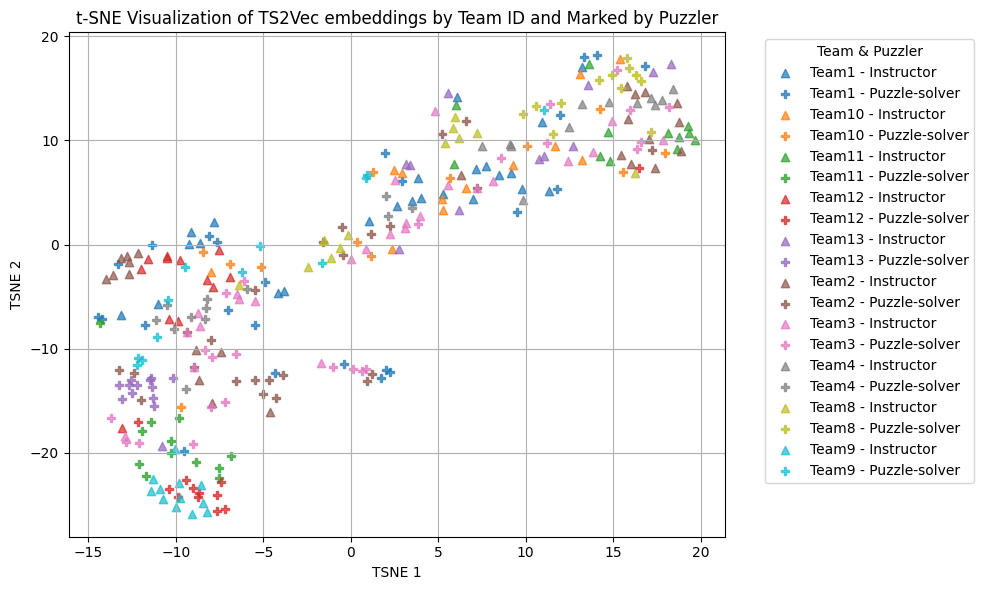

In [56]:
import matplotlib.pyplot as plt

teams = sorted(data['Team_ID'].unique())  # Ensures consistent color mapping

# Use a qualitative colormap suitable for categories
cmap = plt.cm.get_cmap('tab10', len(teams))
team_colors = {team: cmap(i) for i, team in enumerate(teams)}

plt.figure(figsize=(10, 6))

# Plot each team with marker style based on 'Puzzler'
for team in teams:
    for puzzler_value, marker in zip([0, 1], ['^', 'P']):
        subset = data[(data['Team_ID'] == team) & 
                    (data['Puzzler'] == puzzler_value)]

        if not subset.empty:
            plt.scatter(subset['tsne_1'], subset['tsne_2'],
                        label=f"{team} - {'Puzzle-solver' if puzzler_value else 'Instructor'}",
                        color=team_colors[team],
                        marker=marker,
                        alpha=0.7)

plt.title("t-SNE Visualization of TS2Vec embeddings by Team ID and Marked by Puzzler")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Team & Puzzler", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\khali\AppData\Local\Temp\ipykernel_6812\969544267.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(teams))


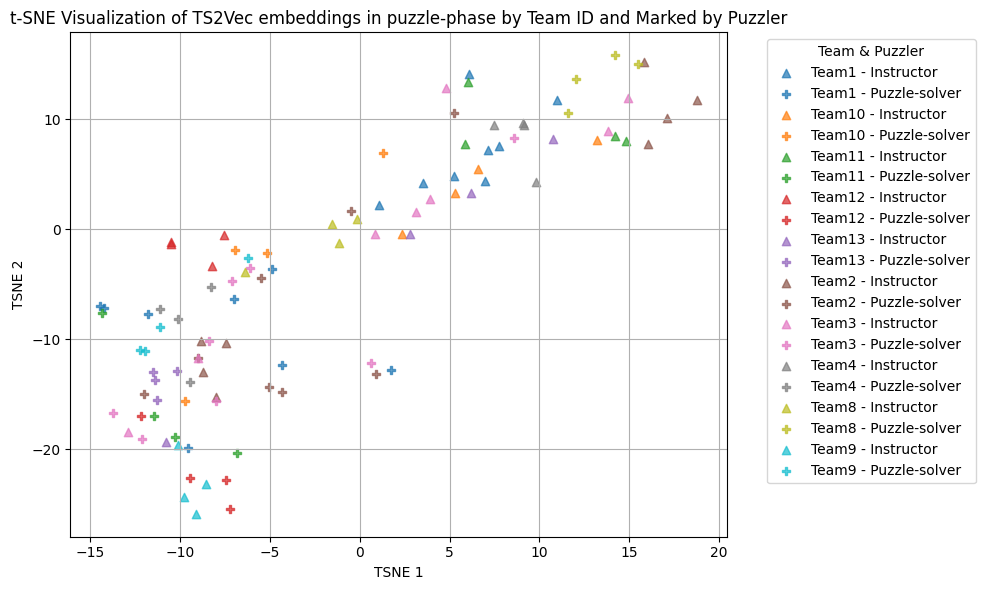

In [54]:
import matplotlib.pyplot as plt

teams = sorted(data['Team_ID'].unique())  # Ensures consistent color mapping

# Use a qualitative colormap suitable for categories
cmap = plt.cm.get_cmap('tab10', len(teams))
team_colors = {team: cmap(i) for i, team in enumerate(teams)}

plt.figure(figsize=(10, 6))

# Plot each team with marker style based on 'Puzzler'
for team in teams:
    for puzzler_value, marker in zip([0, 1], ['^', 'P']):
        subset = data[(data['Team_ID'] == team) & 
                    (data['Puzzler'] == puzzler_value) & 
                    (data['Phase'] == 'phase2')]

        if not subset.empty:
            plt.scatter(subset['tsne_1'], subset['tsne_2'],
                        label=f"{team} - {'Puzzle-solver' if puzzler_value else 'Instructor'}",
                        color=team_colors[team],
                        marker=marker,
                        alpha=0.7)

plt.title("t-SNE Visualization of TS2Vec embeddings in puzzle-phase by Team ID and Marked by Puzzler")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Team & Puzzler", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


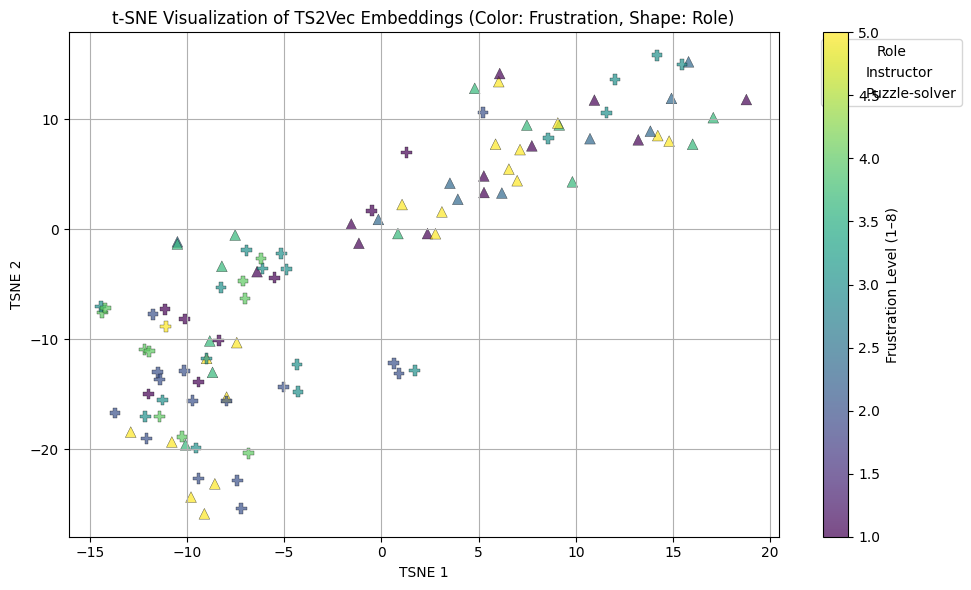

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define marker map for puzzler role
marker_map = {0: '^', 1: 'P'}

# Use continuous colormap suitable for ordinal scale
cmap = 'viridis'

# Plot each role with frustration color
for puzzler_value in [0, 1]:
    subset = data[(data['Puzzler'] == puzzler_value) & (data['Phase'] == 'phase2')]
    if not subset.empty:
        scatter = plt.scatter(subset['tsne_1'], subset['tsne_2'],
                              c=subset['alert'],
                              cmap=cmap,
                              marker=marker_map[puzzler_value],
                              alpha=0.7,
                              edgecolors='black',
                              linewidths=0.3,
                              s=60,
                              label='Puzzle-solver' if puzzler_value else 'Instructor')

plt.title("t-SNE Visualization of TS2Vec Embeddings (Color: Frustration, Shape: Role)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Role", bbox_to_anchor=(1.05, 1), loc='upper left')
cbar = plt.colorbar(scatter)
cbar.set_label("Frustration Level (1–8)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\khali\AppData\Local\Temp\ipykernel_6812\863424697.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


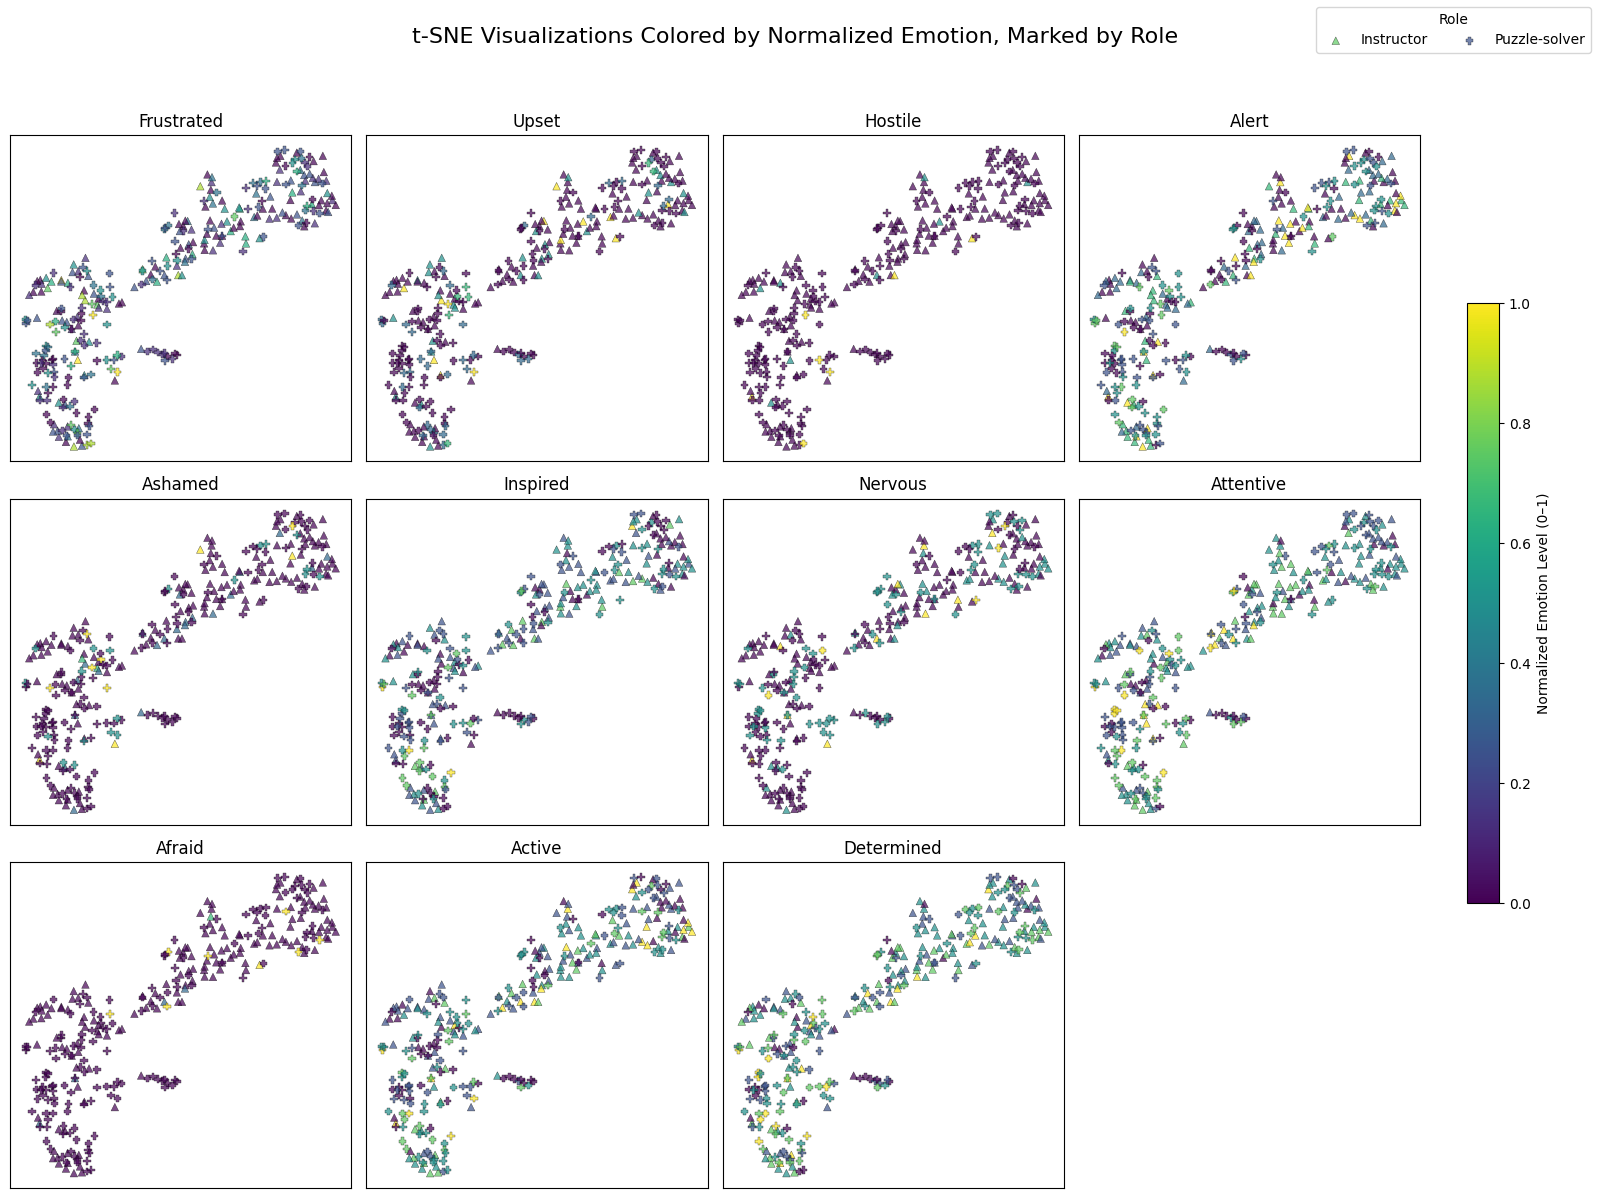

In [80]:
import matplotlib.pyplot as plt

emotion_vars = [
    'Frustrated', 'upset', 'hostile', 'alert', 'ashamed',
    'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined'
]

n_cols = 4
n_rows = (len(emotion_vars) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)
marker_map = {0: '^', 1: 'P'}
cmap = 'viridis'

# Normalize all values to 0–1
normalized_data = data.copy()
for emotion in emotion_vars:
    if emotion in normalized_data.columns:
        max_val = normalized_data[emotion].max()
        min_val = normalized_data[emotion].min()
        if pd.notnull(max_val) and max_val != min_val:
            normalized_data[emotion] = (normalized_data[emotion] - min_val) / (max_val - min_val)
        else:
            normalized_data[emotion] = 0.0  # fallback if constant

for idx, emotion in enumerate(emotion_vars):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    for puzzler_value in [0, 1]:
        subset = normalized_data[
            (normalized_data['Puzzler'] == puzzler_value) &
            #(normalized_data['Phase'] == 'phase2') &
            (emotion in normalized_data.columns)
        ]
        subset = subset.dropna(subset=[emotion])
        if not subset.empty:
            scatter = ax.scatter(subset['tsne_1'], subset['tsne_2'],
                                 c=subset[emotion],
                                 cmap=cmap,
                                 marker=marker_map[puzzler_value],
                                 alpha=0.7,
                                 edgecolors='black',
                                 linewidths=0.3,
                                 s=30,
                                 label='Puzzle-solver' if puzzler_value else 'Instructor')

    ax.set_title(emotion.capitalize())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True)

# Remove unused axes if needed
for i in range(len(emotion_vars), n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

# Add shared colorbar for normalized values
fig.subplots_adjust(right=0.9, hspace=0.4, wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1)), cax=cbar_ax, label='Normalized Emotion Level (0–1)')

# Shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Role', loc='upper right', ncol=2)

plt.suptitle("t-SNE Visualizations Colored by Normalized Emotion, Marked by Role", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [70]:
data['Cohort_n'] = data['Cohort'].apply(lambda x: int(x[3:]))

In [32]:
subset = data[data['Team_ID'] == team]

#also subset over phase = 2
subset = subset[subset['Phase'] == 2]

In [34]:
subset = data[data['Team_ID'] == team]

In [36]:
subset['Phase']

288    phase3
289    phase2
290    phase1
291    phase3
292    phase2
293    phase1
294    phase3
295    phase2
296    phase1
297    phase3
298    phase2
299    phase1
300    phase3
301    phase2
302    phase1
303    phase3
304    phase2
305    phase1
306    phase3
307    phase2
308    phase1
309    phase3
310    phase2
311    phase1
Name: Phase, dtype: object

In [ ]:
#plot 

array([[-0.13885689,  0.01709826,  0.00715075, ..., -0.097265  ,
        -0.09504084, -0.12935208],
       [-0.12783818,  0.00365195, -0.00501664, ..., -0.09826586,
        -0.09574723, -0.13092081],
       [-0.1319506 ,  0.00862318, -0.00053214, ..., -0.09736752,
        -0.0951339 , -0.12958126],
       ...,
       [-0.14824222,  0.02884775,  0.01787258, ..., -0.09676908,
        -0.09463338, -0.12857699],
       [-0.14546891,  0.02519737,  0.01454385, ..., -0.09783245,
        -0.09542505, -0.13020582],
       [-0.1382647 ,  0.01638178,  0.00649804, ..., -0.09867211,
        -0.0960656 , -0.13160852]])

In [85]:
for h in data.columns:
    print(h)

Unnamed: 0
HR_TD_Mean
HR_TD_Median
HR_TD_std
HR_TD_Min
HR_TD_Max
HR_TD_AUC
HR_TD_Kurtosis
HR_TD_Skew
HR_TD_Slope_min
HR_TD_Slope_max
HR_TD_Slope_mean
HR_TD_Slope
TEMP_TD_Mean
TEMP_TD_Median
TEMP_TD_std
TEMP_TD_Min
TEMP_TD_Max
TEMP_TD_AUC
TEMP_TD_Kurtosis
TEMP_TD_Skew
TEMP_TD_Slope_min
TEMP_TD_Slope_max
TEMP_TD_Slope_mean
TEMP_TD_Slope
EDA_TD_P_Mean
EDA_TD_P_Median
EDA_TD_P_std
EDA_TD_P_Min
EDA_TD_P_Max
EDA_TD_P_AUC
EDA_TD_P_Kurtosis
EDA_TD_P_Skew
EDA_TD_P_Slope_min
EDA_TD_P_Slope_max
EDA_TD_P_Slope_mean
EDA_TD_P_Slope
EDA_TD_T_Mean
EDA_TD_T_Median
EDA_TD_T_std
EDA_TD_T_Min
EDA_TD_T_Max
EDA_TD_T_AUC
EDA_TD_T_Kurtosis
EDA_TD_T_Skew
EDA_TD_T_Slope_min
EDA_TD_T_Slope_max
EDA_TD_T_Slope_mean
EDA_TD_T_Slope
EDA_TD_P_Peaks
EDA_TD_P_RT
EDA_TD_P_ReT
Round
Phase
Individual
Puzzler
original_ID
raw_data_path
Team_ID
Frustrated
Cohort
upset
hostile
alert
ashamed
inspired
nervous
attentive
afraid
active
determined
HR_embeddings
EDA_embeddings
BVP_embeddings
TEMP_embeddings
emb_HR_0
emb_EDA_0
emb_BVP

In [90]:
#Drop the following columns from the data frame:
# HR_TD_Mean
# HR_TD_Median
# HR_TD_std
# HR_TD_Min
# HR_TD_Max
# HR_TD_AUC
# HR_TD_Kurtosis
# HR_TD_Skew
# HR_TD_Slope_min
# HR_TD_Slope_max
# HR_TD_Slope_mean
# HR_TD_Slope
# TEMP_TD_Mean
# TEMP_TD_Median
# TEMP_TD_std
# TEMP_TD_Min
# TEMP_TD_Max
# TEMP_TD_AUC
# TEMP_TD_Kurtosis
# TEMP_TD_Skew
# TEMP_TD_Slope_min
# TEMP_TD_Slope_max
# TEMP_TD_Slope_mean
# TEMP_TD_Slope
# EDA_TD_P_Mean
# EDA_TD_P_Median
# EDA_TD_P_std
# EDA_TD_P_Min
# EDA_TD_P_Max
# EDA_TD_P_AUC
# EDA_TD_P_Kurtosis
# EDA_TD_P_Skew
# EDA_TD_P_Slope_min
# EDA_TD_P_Slope_max
# EDA_TD_P_Slope_mean
# EDA_TD_P_Slope
# EDA_TD_T_Mean
# EDA_TD_T_Median
# EDA_TD_T_std
# EDA_TD_T_Min
# EDA_TD_T_Max
# EDA_TD_T_AUC
# EDA_TD_T_Kurtosis
# EDA_TD_T_Skew
# EDA_TD_T_Slope_min
# EDA_TD_T_Slope_max
# EDA_TD_T_Slope_mean
# EDA_TD_T_Slope
# EDA_TD_P_Peaks
# EDA_TD_P_RT
# EDA_TD_P_ReT

data_on = data.drop(columns=[ "HR_TD_Mean",
                        "HR_TD_Median",
                        "HR_TD_std",
                        "HR_TD_Min",
                        "HR_TD_Max",
                        "HR_TD_AUC",
                        "HR_TD_Kurtosis",
                        "HR_TD_Skew",
                        "HR_TD_Slope_min",
                        "HR_TD_Slope_max",
                        "HR_TD_Slope_mean",
                        "HR_TD_Slope",
                        "TEMP_TD_Mean",
                        "TEMP_TD_Median",
                        "TEMP_TD_std",
                        "TEMP_TD_Min",
                        "TEMP_TD_Max",
                        "TEMP_TD_AUC",
                        "TEMP_TD_Kurtosis",
                        "TEMP_TD_Skew",
                        "TEMP_TD_Slope_min",
                        "TEMP_TD_Slope_max",
                        "TEMP_TD_Slope_mean",
                        "TEMP_TD_Slope",
                        "EDA_TD_P_Mean",
                        "EDA_TD_P_Median",
                        "EDA_TD_P_std",
                        "EDA_TD_P_Min",
                        "EDA_TD_P_Max",
                        "EDA_TD_P_AUC",
                        "EDA_TD_P_Kurtosis",
                        "EDA_TD_P_Skew",
                        "EDA_TD_P_Slope_min",
                        "EDA_TD_P_Slope_max",
                        "EDA_TD_P_Slope_mean",
                        "EDA_TD_P_Slope",
                        "EDA_TD_T_Mean",
                        "EDA_TD_T_Median",
                        "EDA_TD_T_std",
                        "EDA_TD_T_Min",
                        "EDA_TD_T_Max",
                        "EDA_TD_T_AUC",
                        "EDA_TD_T_Kurtosis",
                        "EDA_TD_T_Skew",
                        "EDA_TD_T_Slope_min",
                        "EDA_TD_T_Slope_max",
                        "EDA_TD_T_Slope_mean",
                        "EDA_TD_T_Slope",
                        "EDA_TD_P_Peaks",
                        "EDA_TD_P_RT",
                        "EDA_TD_P_ReT" ])

In [93]:
#save data_on
data_on.to_csv('data/HR_data_2_embeddings_only.csv', index=False)

In [46]:
y = data['Frustrated']

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(all_embeddings, y, test_size=0.2, random_state=42)

# Fit regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = reg.predict(X_test)
print("MSE:", mean_absolute_error(y_test, y_pred))


MSE: 2.1218350704414126


In [42]:
data

,Unnamed: 0,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,...,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined,embeddings
0,0,78.663878,76.700,7.480043,67.25,92.48,23048.450,-1.091448,0.369955,-0.730000,...,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."
1,1,76.540732,76.610,2.584756,69.82,82.33,23959.920,-0.245338,0.338732,-0.360000,...,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."
2,2,78.173563,77.920,2.681255,72.22,82.80,20324.605,-0.615922,-0.233047,-0.630000,...,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."
3,3,83.073688,83.880,7.363598,69.42,96.12,24924.300,-0.866610,-0.046021,-0.465000,...,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."
4,4,72.281250,72.910,3.193762,64.95,79.98,23052.100,0.200401,-0.560948,-0.372500,...,1.0,3.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,307,82.019065,78.830,8.794206,69.73,97.18,26244.705,-1.386324,0.251382,-0.517500,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."
308,308,103.274248,104.625,14.208117,68.13,125.52,31523.695,-0.338091,-0.521254,-0.962500,...,1.0,3.0,1.0,1.0,1.0,4.0,1.0,3.0,4.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."
309,309,99.065000,97.490,10.079197,86.55,119.75,28235.230,-0.740136,0.629730,-0.657500,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,4.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."
310,310,91.793354,97.180,19.234169,60.90,120.67,28909.835,-1.229115,-0.181431,-0.717500,...,1.0,3.0,1.0,3.0,1.0,4.0,1.0,4.0,4.0,"[[[-0.05565757, -0.03793873, -0.04383092, -0.0..."


In [8]:
dat_1 = hr_eda_bvp_temp.to_numpy()  # shape: (T, 4)
dat_1 = dat_1[np.newaxis, :, :]

In [32]:
dat_1.shape

(1, 18855, 5)

In [9]:
dat_1.shape

(1, 18855, 5)

In [10]:
from etna.transforms.embeddings.models import TS2VecEmbeddingModel

/home/khalil/miniconda3/envs/env_works/lib/python3.10/site-packages/etna/settings.py:51: UserWarning: etna[chronos] is not available, to install it, run `pip install etna[chronos]`
  warnings.warn("etna[chronos] is not available, to install it, run `pip install etna[chronos]`")
/home/khalil/miniconda3/envs/env_works/lib/python3.10/site-packages/etna/settings.py:66: UserWarning: etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`
  warnings.warn("etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`")
/home/khalil/miniconda3/envs/env_works/lib/python3.10/site-packages/etna/settings.py:82: UserWarning: etna[prophet] is not available, to install it, run `pip install etna[prophet]`
  warnings.warn("etna[prophet] is not available, to install it, run `pip install etna[prophet]`")
/home/khalil/miniconda3/envs/env_works/lib/python3.10/site-packages/etna/settings.py:91: UserWarning: etna[classification] is not available, to install it, run `pi

In [ ]:
from etna.transforms.embeddings.models import TS2VecEmbeddingModel

# List available pretrained models
available_models = TS2VecEmbeddingModel.list_models()
print(available_models)

# Load a specific pretrained model
model = TS2VecEmbeddingModel.load(model_name='ts2vec_tiny')
model.embedding_model.batch_size = 1


['ts2vec_tiny']


In [20]:
dat_1.shape

(1, 18855, 5)

In [21]:
model.embedding_model.batch_size = 1

In [29]:
dat_1[:,:,0,None].shape

(1, 18855, 1)

In [31]:
model.embedding_model.encode(dat_1[:,:,0,None]).shape

(1, 18855, 16)

In [13]:
df.iloc[0]

t_seconds      0.00
Unnamed: 0     0.00
TEMP          31.17
Name: 0, dtype: float64

In [25]:
#Use the TS2Vec model to encode the time series data, pooling the time series data to a single vector
from ts2vec import TS2Vec
model = TS2Vec(input_dims=5)
embedding = model.encode(dat_1,encoding_window='full_sequence')
embedding.shape

(1, 18855, 320)

In [27]:
#maxpooling across dim=1 using numpy
embedding = np.max(embedding, axis=1)
embedding.shape


(1, 320)

In [20]:
embedding[0][0]

array([ -9.485781  ,  13.332074  , -16.295546  ,  -5.3082547 ,
        -8.434439  ,  -7.246311  ,  -0.92227983,  10.377557  ,
         5.8486757 ,  -4.2260165 ,  10.616538  ,  -3.049604  ,
        -8.237917  ,   9.703344  ,   8.291063  , -13.267677  ,
         2.1475034 ,  -2.1767588 ,  -9.245678  ,  -1.6883235 ,
         7.218567  ,  -5.460306  ,   0.48868537,  -8.35013   ,
         0.81740713,  18.342293  ,  12.174667  ,  -0.27726412,
        14.329578  , -10.779439  ,  -5.621278  ,  -3.6623874 ,
         7.658205  , -13.077543  ,   0.2083444 ,   6.2842484 ,
        23.968235  ,  -3.4631057 ,   5.0482955 ,   2.4785128 ,
       -11.997673  ,   1.6916022 ,  24.21688   , -22.794752  ,
         0.86318827,  -0.5043845 ,  38.091522  , -20.266485  ,
        -2.5980997 ,  -8.165831  ,   1.6012913 ,   4.8163714 ,
         2.940488  ,   6.66364   , -14.669049  ,  11.283632  ,
       -12.573567  ,   9.048862  ,  -0.9166999 ,  13.437372  ,
        -7.2853518 ,   2.5603375 ,  16.68581   ,   1.63